In [148]:
#already built in with python
import os
import datetime 

#installed with conda-forge
import numpy
import xarray as xr
import matplotlib as plt
import folium
import geopandas as gpd
from shapely.geometry import Point

#installed with pip 
import pystac
import pystac_client
import rasterio

# **Same visuals, but different on the inside**
----

The new Earth Observation Processing Framework (**EOPF**) Zarr format is changing the way Sentinel products are delivered. The already .SAFE format will no longer exist to be replaced by Zarr data but don't be scared, Sentinel data is the same, just the storage format and delivery is different. Let's take a look...

## **STAC catalog**
------
The STAC catalog, when you can access the data, has the same apearance and organization schema!

| ![Image 1](img/old.png) | ![Image 2](img/zarr.png) |
|---------------------------------|------------------------|
| CDSE - STAC API                 | EOPF Sentinel Zarr Samples Service STAC API              


But, if you notice carefully, there is a small but significant difference: the EOPF Zarr service has Sentinel-1 SLC data, which didn't exist in the old CDSE STAC catalogue. The main reason for this is the the new Zarr format, because it's cloud-native, can handle in a much simpler way, heavier data, such as Sentinel-1 SLC data (*not only contains the backscatter information, but also the phase informtion, which is essential for InSAR, but we'll talk about that later*)

**Access the data using ID** - The way data is presented is the same, even though the way it is stored is not the same. These are great news! If you want to access a specif product, it still follows the same logic and it did for the CDSE - STAC catalog.

Let's follow this example on how to access Sentinel-1 Level-1 GRD data to see how the data is stored on the EOPF Sentinel Zarr Samples Service.

### 1. Source ID for the STAC

<img src="img/source_id_catalogue.png" width="500"/>

In [149]:
stacID = "eopf-sample-service-stac-api"
stacURL = "https://stac.core.eopf.eodc.eu/"

### 2. Source ID for Sentinel-1 Level-1 GRD

<img src="img/source_id_grd.png" width="500"/>

In [150]:
grdID = "sentinel-2-l2a"
grdURL = "https://stac.core.eopf.eodc.eu/collections/sentinel-2-l2a"

### 3. Source ID for the specific product

<img src="img/source_id_product.png" width="500"/>

In [152]:
productID = "S2B_MSIL2A_20250707T112119_N0511_R037_T29SMD_20250707T133709"
productURL = "https://stac.core.eopf.eodc.eu/collections/sentinel-2-l2a/items/S2C_MSIL2A_20250702T112141_N0511_R037_T29SNC_20250702T162819"

## **But attention** 🚨
---

- If by any chance you try to look for the same product but on the old catalog we'll find basically the same product but with a different identification name. Are those the same products? Why do they have different names?

Let's dive into this problem!


#### **1. ID names of products**
Let's analyse the ID names of Sentinel products!

Each Sentinel product follows a similar structure, having identifiers to distiguish between products. Each product can be seen a "photo" taken by the satellite and, for each photo, the information is stored under this product ID names.

In [153]:
print("Product ID =", productID)

Product ID = S2B_MSIL2A_20250707T112119_N0511_R037_T29SMD_20250707T133709


And, because this product belongs to a specif group of products (Sentinel-1 Level-1 GRD but it could be, Sentinel-1 Level-1 SLC or Sentinel-1 Level-2A), it also has a collection ID.

In [154]:
print("Collection ID =", grdID)

Collection ID = sentinel-2-l2a


In the end, all the products from all the collections are stored on the same STAC catalog.

In [155]:
print("Catalog ID =", stacID)

Catalog ID = eopf-sample-service-stac-api


------

Now let's breakdown the point product name from the EOPF Sentinel Zarr Samples Service: 

1- ```S1A_IW_GRDH_1SSH_20250708T124813_20250708T124838_059992_0773EF_6FFD``` 

and compare it with the same product from the old STAC catalog: 

2- ```S1A_IW_GRDH_1SSH_20250708T124813_20250708T124838_059992_0773EF_E620_COG```

Product from EOPF Sentinel Zarr Samples Service: `S1A_IW_GRDH_1SSH_20250708T124813_20250708T124838_059992_0773EF_6FFD`:

| Part                 | Value               | Meaning                                                                |
|----------------------|---------------------|------------------------------------------------------------------------|
| **S1A**              | S1A                 | **Satellite**: Sentinel-1A                                             |
| **IW**               | IW                  | **Acquisition Mode**: Interferometric Wide Swath                       |
| **GRDH**             | GRDH                | **Product Type**: Ground Range Detected (GRD), High resolution         |
| **1SSH**             | 1SDV                | **Product Level and Polarisation**: Level-1, Dual polarization (VV+VH) |
| **20250708T124813**  | 08-07-2025 12:48:13 | **Start Time** (UTC): acquisition start time                           |
| **20250708T124838**  | 08-07-2025 12:48:38 | **Stop Time** (UTC): acquisition end time                              |
| **059992**           | 059992              | **Absolute Orbit Number**: Sequential number representing how many complete orbits the satellite has made since launch. It increases by 1 for each orbit (approx. every 98 minutes)                          |
| **0773EF**           | 0773EF              | **Mission Data Take ID**: It increases each time the sensor is turned on, kind of identifying a "recording session". It is useful to identify if two products were taken on the same continuous acquisition                                                |
| **6FFD**             | 6FFD                | **Unique Identifier / Product ID**: It is unique for each product, similar to an ID number|

-------

Now, let's compare the two products!

`S1A_IW_GRDH_1SSH_20250708T124813_20250708T124838_059992_0773EF_6FFD` vs `S1A_IW_GRDH_1SSH_20250708T124813_20250708T124838_059992_0773EF_E620_COG`


|      | EOPF Sentinel Zarr Samples Service | old STAC catalog   |  Is it the same?|   
|--------------------------------------|---------------------|--------------------------------------------------------------|-----|
| **Satellite**                        | S1A                 | S1A                                            |✅|
| **Acquisition Mode**                 | IW                  | IW                       |✅|
| **Product Type**                     | GRDH                | GRDH         |✅|
| **Product Level and Polarisation**   | 1SSH                | 1SSH|✅|
| **Start Time**                       | 08-07-2025 12:48:13 |08-07-2025 12:48:13|✅|
| **Stop Time**                        | 08-07-2025 12:48:38 |08-07-2025 12:48:38|✅|
| **Absolute Orbit Number**            | 059992              | 059992                                              |✅|
| **Mission Data Take ID**             | 0773EF              |0773EF                                               |✅|
| **Unique Identifier**                | 6FFD                | E620                                     |❌|
| **Extra Notation**                | -             | COG                                     |❌|

What does this mean? In fact, these are exactly the same products, just the unique identifier and the extra notation is different. This is because:
- The 6FFD unique identifier shows the original ESA-generated product ID, created when the scene was first processed and the E620 identifier was generated when the file was reprocessed and converted into a COG (Cloud Optimized GeoTIFF).
- This leads us to the extra notation found on the old STAC catalog. The COG suffix	indicates the product was repackaged for cloud/web use and, of course, converted into a COG (Cloud Optimized GeoTIFF). We don't face this situation on the new Zarr format.

## **Navigating on the EOPF Zarr STAC**
---
Starting from the begining, let's navigate through the STAC catalog until we find the dataset and products we want - Sentinel-1 GRD!

In [156]:
import requests
from typing import List, Optional, cast
from pystac import Collection, MediaType
from pystac_client import Client, CollectionClient
from datetime import datetime

As a starting point, we need to establish the connection with the EOPF Sentinel Zarr Sample Service STAC Catalog. In fact, we already have the URL link for the catalog, as you can see the following print!

In [157]:
print(stacURL)

https://stac.core.eopf.eodc.eu/


With a function called ``Client.open()`` we can see the organizational tree of the catalog itself! We are on the right path! 

In [158]:
eopf_catalog = Client.open(stacURL) 
eopf_catalog

<Client id=eopf-sample-service-stac-api>

In [159]:
print('ID:              ', eopf_catalog.id)
print('Title:           ', eopf_catalog.title)
print('Description:     ', eopf_catalog.description)
print('Links:           ', eopf_catalog.links)

ID:               eopf-sample-service-stac-api
Title:            EOPF Sentinel Zarr Samples Service STAC API
Description:      STAC catalog of the EOPF Sentinel Zarr Samples Service
Links:            [<Link rel=self target=https://stac.core.eopf.eodc.eu/>, <Link rel=root target=<Client id=eopf-sample-service-stac-api>>, <Link rel=data target=https://stac.core.eopf.eodc.eu/collections>, <Link rel=conformance target=https://stac.core.eopf.eodc.eu/conformance>, <Link rel=search target=https://stac.core.eopf.eodc.eu/search>, <Link rel=search target=https://stac.core.eopf.eodc.eu/search>, <Link rel=http://www.opengis.net/def/rel/ogc/1.0/queryables target=https://stac.core.eopf.eodc.eu/queryables>, <Link rel=child target=https://stac.core.eopf.eodc.eu/collections/sentinel-2-l2a>, <Link rel=child target=https://stac.core.eopf.eodc.eu/collections/sentinel-3-slstr-l1-rbt>, <Link rel=child target=https://stac.core.eopf.eodc.eu/collections/sentinel-3-olci-l2-lfr>, <Link rel=child target=https://s

Now that the catalog connection was established we can take a look at all the collections available at the STAC catalog and, hopefully, find the Sentinel-1 GRD! To do so we'll use a function called ``get_all_collections()``, which will list all the collections available on the catalog.

Because the STAC catalog is still under development, not all the collections under the catalog are valid. To avoid getting a long error message we print the collections ID this way, showing only the collections valid and active!

In [160]:
try:
    for collections in eopf_catalog.get_all_collections():
        print(collections.id)
except Exception:
    print(
        "* [https://github.com/EOPF-Sample-Service/eopf-stac/issues/18 where you can check the progress of this issue]"
    )

sentinel-2-l2a
sentinel-3-slstr-l1-rbt
sentinel-3-olci-l2-lfr
sentinel-2-l1c
sentinel-3-slstr-l2-lst
sentinel-1-l1-slc
sentinel-3-olci-l1-efr
sentinel-3-olci-l1-err
sentinel-1-l2-ocn
sentinel-1-l1-grd
* [https://github.com/EOPF-Sample-Service/eopf-stac/issues/18 where you can check the progress of this issue]


Taking a close look we see that Sentinel-1 GRD collection is active and it matches the ID name we store in the beggining.

In [161]:
print("Our collection ID as we stored it before:", grdID)

try:
    for collections in eopf_catalog.get_all_collections():
        if collections.id == grdID:
            print("It's a match!")
except Exception:
    print()

Our collection ID as we stored it before: sentinel-2-l2a
It's a match!



Similar to function used before, we'll use the ``get_collection()``function, since we already know the ID of the collection we want to access. After this we'll be able to get more useful information about Sentinel-1 GRD collection! **We are already inside the Sentinel-1 GRD catalog**, now it's time to start looking for useful and meaningful products we can work with.

In [162]:
s2 = eopf_catalog.get_collection(grdID)
s2

<CollectionClient id=sentinel-2-l2a>

In [163]:
print('ID:              ', s2.id)
print('Title:           ', s2.title)
print('Description:     ', s2.description)
print('License:         ', s2.license)
print('Keywords:        ', s2.keywords)
print('Providers:       ', s2.providers)
print('Extent:          ', s2.extent)
print('Links:           ', s2.links)
print('Assets:          ', s2.assets)

ID:               sentinel-2-l2a
Title:            Sentinel-2 Level-2A
Description:      The Sentinel-2 Level-2A Collection 1 product provides orthorectified Surface Reflectance (Bottom-Of-Atmosphere: BOA), with sub-pixel multispectral and multitemporal registration accuracy. Scene Classification (including Clouds and Cloud Shadows), AOT (Aerosol Optical Thickness) and WV (Water Vapour) maps are included in the product.
License:          proprietary
Keywords:         ['Copernicus', 'Sentinel', 'EU', 'ESA', 'Satellite', 'Global', 'Imagery', 'Reflectance']
Providers:        [<pystac.provider.Provider object at 0x169f077e0>, <pystac.provider.Provider object at 0x169f050f0>, <pystac.provider.Provider object at 0x169f05160>]
Extent:           <pystac.collection.Extent object at 0x169f51df0>
Links:            [<Link rel=items target=https://stac.core.eopf.eodc.eu/collections/sentinel-2-l2a/items>, <Link rel=parent target=https://stac.core.eopf.eodc.eu/>, <Link rel=root target=<Client id=eopf

##### **summarizing**:
- ``Client.open()``: to access the catalog;
- ``get_all_collections()``: to check all the collection available on the catalog;
- ``get_collection()``: to get a specif collection we want to work with;

## **Searching and filtering inside a EOPF Zarr STAC collection**
---
The next step is to search and look for products inside the collection we chose!

One of the most basic functions we'll use, and probably one of the most important ones is the ``.search()``function. It will allow us to search and filter for collections and products inside a catalog.

We can filter the search on the catalog by using the following elements:
1. **Collections**: using `collections =`, it filters the catalog by the collections, choosing the searching names like **'sentinel-2-l2a'**, **'sentinel-1-l1-grd'** or **'sentinel-1-l1-slc'**;
2. **Date and Time**: using `datetime =`, it filters the catalog by the time interval in which the products can be found. The search should follow this format: **'2020-05-01T00:00:00Z/2025-05-31T23:59:59.999999Z'**, but if you want you can also exclude the time part;
3. **Area of Interest**: using `bbox = ()` and inserting the lat and long values for the top left corner and bottom right corner of the AOI;
4. **IDs**: using `ids =`, it filters the catalog by the source ID of the product, returning only the product matching that ID;

The following function, ``list_found_elements``is pretty useful for the next few steps because it will help us construct a list from any search result we might get.

In [164]:
def list_found_elements(search_result):
    ids = []
    coll = []
    for item in search_result.items(): 
        ids.append(item.id)
        coll.append(item.collection_id)
    return ids , coll

- Search by collection and datetime

In [165]:
search_catalog_collection_datetime = eopf_catalog.search(
    collections = 'sentinel-2-l2a', #sentinel-1 GRD collection
    datetime = "2025-07-01T07:00:00Z/2025-07-01T08:10:01Z" #15 minutes of acquisition on 01 July 2025
) 

print("This is how our search literally looks: ", search_catalog_collection_datetime)

collection_datetime_items = list_found_elements(search_catalog_collection_datetime)
print("Found", len(collection_datetime_items[0]), "products on this search.")
print(collection_datetime_items[0])

This is how our search literally looks:  <pystac_client.item_search.ItemSearch object at 0x169f718d0>
Found 36 products on this search.
['S2A_MSIL2A_20250701T080501_N0511_R135_T37QEV_20250701T101719', 'S2A_MSIL2A_20250701T080501_N0511_R135_T37QEU_20250701T101719', 'S2A_MSIL2A_20250701T080501_N0511_R135_T37QEB_20250701T101719', 'S2A_MSIL2A_20250701T080501_N0511_R135_T37QEA_20250701T101719', 'S2A_MSIL2A_20250701T080501_N0511_R135_T37QDV_20250701T101719', 'S2A_MSIL2A_20250701T080501_N0511_R135_T37QDU_20250701T101719', 'S2A_MSIL2A_20250701T080501_N0511_R135_T37QDB_20250701T101719', 'S2A_MSIL2A_20250701T080501_N0511_R135_T37QDA_20250701T101719', 'S2A_MSIL2A_20250701T080501_N0511_R135_T37QCV_20250701T101719', 'S2A_MSIL2A_20250701T080501_N0511_R135_T37QCU_20250701T101719', 'S2A_MSIL2A_20250701T080501_N0511_R135_T37QCB_20250701T101719', 'S2A_MSIL2A_20250701T080501_N0511_R135_T37QCA_20250701T101719', 'S2A_MSIL2A_20250701T080501_N0511_R135_T37PET_20250701T101719', 'S2A_MSIL2A_20250701T080501_N05

- Search by ID

In [167]:
search_catalog_ID = eopf_catalog.search(
    ids = 'S2B_MSIL2A_20250707T112119_N0511_R037_T29SMD_20250707T133709' 
)

print("This is how our search literally looks: ", search_catalog_ID)

ID_items = list_found_elements(search_catalog_ID)
print("Found", len(ID_items[0]), "product on this search.")
print(ID_items[0])

This is how our search literally looks:  <pystac_client.item_search.ItemSearch object at 0x169f890d0>
Found 1 product on this search.
['S2B_MSIL2A_20250707T112119_N0511_R037_T29SMD_20250707T133709']


- Search collection, datetime and area of interest

In [168]:
search_catalog_all = eopf_catalog.search(
    collections = 'sentinel-2-l2a', #sentinel-1 GRD collection
    datetime = "2025-07-06T00:00:00Z/2025-07-07T23:59:59Z", #acquisitions on the 06 July 2025 and 07 July 2025
    bbox=(-9.283880, 38.634131, #top left corner of AOI
          -8.964918, 38.810976) #bottom right corner of AOI
) 

print("This is how our search literally looks: ", search_catalog_all)

time_items = list_found_elements(search_catalog_all)
print("Found", len(time_items[0]), "products on this search.")
print(time_items[0])

This is how our search literally looks:  <pystac_client.item_search.ItemSearch object at 0x3021d5910>
Found 8 products on this search.
['S2A_MSIL2A_20250707T113341_N0511_R080_T29SND_20250707T164623', 'S2A_MSIL2A_20250707T113341_N0511_R080_T29SNC_20250707T164623', 'S2A_MSIL2A_20250707T113341_N0511_R080_T29SMD_20250707T164623', 'S2A_MSIL2A_20250707T113341_N0511_R080_T29SMC_20250707T164623', 'S2B_MSIL2A_20250707T112119_N0511_R037_T29SND_20250707T133709', 'S2B_MSIL2A_20250707T112119_N0511_R037_T29SNC_20250707T133709', 'S2B_MSIL2A_20250707T112119_N0511_R037_T29SMD_20250707T133709', 'S2B_MSIL2A_20250707T112119_N0511_R037_T29SMC_20250707T133709']


Finally, we need to actually access the items that we've been filtering on the STAC catalog. To do that we need to get their storage location in the cloud, getting its URL link, something similar to his one: `https://objects.eodc.eu/e05ab01a9d56408d82ac32d69a5aae2a:202507-s01siwgrh/06/products/cpm_v256/S1A_IW_GRDH_1SDV_20250706T183538_20250706T183603_059967_077303_4A58.zarr`.

To do so

In [169]:
product_id = ID_items[0][0] #[0][0] ids and columns, it would print the id of the product we want

item = s2.get_item(product_id) #basically looking for the product with ID we wanted on a specific catalog

zarr_assets = item.get_assets(media_type=MediaType.ZARR)

assets_loc = [zarr_assets]
the_item = assets_loc[0]

print('URL for accessing', product_id, 'item:  ', the_item['product'].href)


URL for accessing S2B_MSIL2A_20250707T112119_N0511_R037_T29SMD_20250707T133709 item:   https://objects.eodc.eu:443/e05ab01a9d56408d82ac32d69a5aae2a:202507-s02msil2a/07/products/cpm_v256/S2B_MSIL2A_20250707T112119_N0511_R037_T29SMD_20250707T133709.zarr


Inside the .zarr asset we got we have the following metadata, which corresponds exactly to the assets found on the STAC API 

In [170]:
print(list(the_item.keys()))

['SR_10m', 'SR_20m', 'SR_60m', 'AOT_10m', 'B01_20m', 'B02_10m', 'B03_10m', 'B04_10m', 'B05_20m', 'B06_20m', 'B07_20m', 'B08_10m', 'B09_60m', 'B11_20m', 'B12_20m', 'B8A_20m', 'SCL_20m', 'TCI_10m', 'WVP_10m', 'product']


<img src="img/metadata.png" width="400"/>


##### **summarizing**:
- ``.search()``: filtering elements inside a catalog;
- ``list_found_elements()``: to list the elements found with the search parameters;
- ``.get_item()``: gets the product with that ID froma. specific catalog;
- ``.get_assets(media_type=MediaType.ZARR)``: get the URL .zarr from the assets stored;
- ``.keys()``: get the URL .zarr from the assets stored;

## **Discovering the groups and sub grouops inside a Zarr product**
----
Now that we've found a specific product we want to work with, let's try to understand how everything is structured inside of it. We'll work with this product: `S1A_IW_GRDH_1SDV_20250706T183538_20250706T183603_059967_077303_4A58`!

The new Zarr format stores Sentinel data in four different groups. It is important to understand this structure because later, when we'll need to access the data, we'll need to know where to find it.

The EOPF Zarr Sentinel structure contains four main groups:
- **Attributes**: STAC format metadata of the imagery, such as chunking information (how the data is divided into the several chunks) and product specific metadata (like acquisition time or sensor specifics);
- **Measurements**: Main retrieved variables, such as reflectance (for Sentinel-1 GRD) and phase information (for Sentinel-1 SLC) or the several band information (when talking about Sentinel-2);
- **Conditions**: Geometric angles, meteorological and instrumental data or any other information concerning;
- **Quality**: Quality information concerning the measurements and masks;

-----

To start accessing and exploring the data we'll need the following libraries:

In [171]:
import os
import xarray as xr

In [172]:
eopf_catalog #the catalog we created the connection with

<Client id=eopf-sample-service-stac-api>

In [173]:
s2 #the collection we are working on

<CollectionClient id=sentinel-2-l2a>

We'll be working the product we lready filtered: ``S1A_IW_GRDH_1SDV_20250706T183538_20250706T183603_059967_077303_4A58`` and the correspondent URL for the assets!

In [174]:
zarr_product_URL = the_item['product'].href

print("These are the asstes we can access:", the_item.keys())
print("This is the URL for the .zarr product:", zarr_product_URL)
print("For for example, this would be the URL for the .zarr B01_20m product:", the_item['B01_20m'].href)

These are the asstes we can access: dict_keys(['SR_10m', 'SR_20m', 'SR_60m', 'AOT_10m', 'B01_20m', 'B02_10m', 'B03_10m', 'B04_10m', 'B05_20m', 'B06_20m', 'B07_20m', 'B08_10m', 'B09_60m', 'B11_20m', 'B12_20m', 'B8A_20m', 'SCL_20m', 'TCI_10m', 'WVP_10m', 'product'])
This is the URL for the .zarr product: https://objects.eodc.eu:443/e05ab01a9d56408d82ac32d69a5aae2a:202507-s02msil2a/07/products/cpm_v256/S2B_MSIL2A_20250707T112119_N0511_R037_T29SMD_20250707T133709.zarr
For for example, this would be the URL for the .zarr B01_20m product: https://objects.eodc.eu:443/e05ab01a9d56408d82ac32d69a5aae2a:202507-s02msil2a/07/products/cpm_v256/S2B_MSIL2A_20250707T112119_N0511_R037_T29SMD_20250707T133709.zarr/measurements/reflectance/r20m/b01


We'll use some funtions from the ``xarray``library. 

The ``open_datatree()`` function allows us to open hierarchical datasets, which is a fancy way to say that our dataset is structured in folders (in our case called groups) and subfolders (or subgroups) - exactly the Zarr format situation. So, in conclusion, using this function will allow us to **load the entire structure of groups and subgroups into accessible objects, where we can navigate, inspect and extract data from any level**.

On the other hand, if we prefer to **open just one group at a time** (intead of unfolding the whole dataset tree), we can use ``open_dataset()``funtion and proceed with the same inspection.

In [175]:
sample_tree = xr.open_datatree(zarr_product_URL,
    engine = "zarr", 
    chunks={}
                              )

#sample_tree = xr.open_datatree(zarr_product_URL, engine = "zarr", chunks={})
print(sample_tree)

/var/folders/m1/jbwb10r115nghdm3qdhnjtnm0000gn/T/ipykernel_33353/2927127211.py:1: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  sample_tree = xr.open_datatree(zarr_product_URL,
/var/folders/m1/jbwb10r115nghdm3qdhnjtnm0000gn/T/ipykernel_33353/2927127211.py:1: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta6

<xarray.DataTree>
Group: /
│   Attributes:
│       other_metadata:  {'AOT_retrieval_model': 'SEN2COR_DDV', 'L0_ancillary_dat...
│       stac_discovery:  {'assets': {'analytic': {'eo:bands': [{'center_wavelengt...
├── Group: /conditions
│   ├── Group: /conditions/geometry
│   │       Dimensions:                        (angle: 2, band: 13, y: 23, x: 23,
│   │                                           detector: 4)
│   │       Coordinates:
│   │         * angle                          (angle) <U7 56B 'zenith' 'azimuth'
│   │         * band                           (band) <U3 156B 'b01' 'b02' ... 'b11' 'b12'
│   │         * detector                       (detector) int64 32B 1 2 3 4
│   │         * x                              (x) int64 184B 399960 404960 ... 509960
│   │         * y                              (y) int64 184B 4400040 4395040 ... 4290040
│   │       Data variables:
│   │           mean_sun_angles                (angle) float64 16B dask.array<chunksize=(2,), meta=np.ndar

In [176]:
sample_set = xr.open_dataset(zarr_product_URL,
    engine = "zarr", 
    chunks={}
                            )

#sample_set = xr.open_dataset(zarr_product_URL, engine = "zarr", chunks={})
print(sample_set)

<xarray.Dataset> Size: 0B
Dimensions:  ()
Data variables:
    *empty*
Attributes:
    other_metadata:  {'AOT_retrieval_model': 'SEN2COR_DDV', 'L0_ancillary_dat...
    stac_discovery:  {'assets': {'analytic': {'eo:bands': [{'center_wavelengt...


In [177]:
for i in sorted(sample_tree.groups):
    print(i)

/
/conditions
/conditions/geometry
/conditions/mask
/conditions/mask/detector_footprint
/conditions/mask/detector_footprint/r10m
/conditions/mask/detector_footprint/r20m
/conditions/mask/detector_footprint/r60m
/conditions/mask/l1c_classification
/conditions/mask/l1c_classification/r60m
/conditions/mask/l2a_classification
/conditions/mask/l2a_classification/r20m
/conditions/mask/l2a_classification/r60m
/conditions/meteorology
/conditions/meteorology/cams
/conditions/meteorology/ecmwf
/measurements
/measurements/reflectance
/measurements/reflectance/r10m
/measurements/reflectance/r20m
/measurements/reflectance/r60m
/quality
/quality/atmosphere
/quality/atmosphere/r10m
/quality/atmosphere/r20m
/quality/atmosphere/r60m
/quality/l2a_quicklook
/quality/l2a_quicklook/r10m
/quality/l2a_quicklook/r20m
/quality/l2a_quicklook/r60m
/quality/mask
/quality/mask/r10m
/quality/mask/r20m
/quality/mask/r60m
/quality/probability
/quality/probability/r20m


**the following doesn't print anything because it's not loading anything and the group is empty**

In [178]:
for i in sorted(sample_set):
    print(i)

In [179]:
import zarr
zarr_store = zarr.open(zarr_product_URL, mode='r')
print(zarr_store.tree())

/


In [180]:
measurements_groups = []
for i in sorted(sample_tree.groups):
    if "measurements" in i:
        measurements_groups.append(i)
print(measurements_groups)

['/measurements', '/measurements/reflectance', '/measurements/reflectance/r10m', '/measurements/reflectance/r20m', '/measurements/reflectance/r60m']


In [181]:
c_sentinel2 = eopf_catalog.get_collection('sentinel-2-l2a')
#Choosing the first item available to be opened:
item= c_sentinel2.get_item(product_id)
item_assets = item.get_assets(media_type=MediaType.ZARR)

cloud_storage = item_assets['product'].href

print('Item cloud storage URL for retrieval:',cloud_storage)

Item cloud storage URL for retrieval: https://objects.eodc.eu:443/e05ab01a9d56408d82ac32d69a5aae2a:202507-s02msil2a/07/products/cpm_v256/S2B_MSIL2A_20250707T112119_N0511_R037_T29SMD_20250707T133709.zarr


In [182]:
dt = xr.open_datatree(
    cloud_storage,        # the cloud storage url from the Item we are interested in
    engine="zarr",      # visualisation mode
    chunks={})            # default eopf chunking size

for dt_group in sorted(dt.groups):
    print("DataTree group {group_name}".format(group_name=dt_group)) # getting the available groups

/var/folders/m1/jbwb10r115nghdm3qdhnjtnm0000gn/T/ipykernel_33353/911915994.py:1: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  dt = xr.open_datatree(
/var/folders/m1/jbwb10r115nghdm3qdhnjtnm0000gn/T/ipykernel_33353/911915994.py:1: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is 

DataTree group /
DataTree group /conditions
DataTree group /conditions/geometry
DataTree group /conditions/mask
DataTree group /conditions/mask/detector_footprint
DataTree group /conditions/mask/detector_footprint/r10m
DataTree group /conditions/mask/detector_footprint/r20m
DataTree group /conditions/mask/detector_footprint/r60m
DataTree group /conditions/mask/l1c_classification
DataTree group /conditions/mask/l1c_classification/r60m
DataTree group /conditions/mask/l2a_classification
DataTree group /conditions/mask/l2a_classification/r20m
DataTree group /conditions/mask/l2a_classification/r60m
DataTree group /conditions/meteorology
DataTree group /conditions/meteorology/cams
DataTree group /conditions/meteorology/ecmwf
DataTree group /measurements
DataTree group /measurements/reflectance
DataTree group /measurements/reflectance/r10m
DataTree group /measurements/reflectance/r20m
DataTree group /measurements/reflectance/r60m
DataTree group /quality
DataTree group /quality/atmosphere
Data

In [192]:
# Get /measurements/reflectance/r20m group
groups = list(dt.groups)
interesting_groups = [
    group for group in groups if group.startswith('/quality/l2a_quicklook/r20m')
    and dt[group].ds.data_vars
]
print(f"\n🔍 Searching for groups with data variables in '/measurements/reflectance/r20m'...")


🔍 Searching for groups with data variables in '/measurements/reflectance/r20m'...


In [184]:
if interesting_groups:
    sample_group = interesting_groups[0]
    group_ds = dt[sample_group].ds
    
    print(f"Group '{sample_group}' Information")
    print("=" * 50)
    print(f"Dimensions: {dict(group_ds.dims)}")
    print(f"Data Variables: {list(group_ds.data_vars.keys())}")
    print(f"Coordinates: {list(group_ds.coords.keys())}")

else:
    print("No groups with data variables found in the first 5 groups.")

Group '/measurements/reflectance/r20m' Information
Dimensions: {'y': 5490, 'x': 5490}
Data Variables: ['b01', 'b02', 'b03', 'b04', 'b05', 'b06', 'b07', 'b11', 'b12', 'b8a']
Coordinates: ['x', 'y']


/var/folders/m1/jbwb10r115nghdm3qdhnjtnm0000gn/T/ipykernel_33353/1451209294.py:7: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  print(f"Dimensions: {dict(group_ds.dims)}")


In [185]:
# Examine the root dataset
root_dataset = dt.ds

print("Root Dataset Metadata")

if root_dataset.attrs:
    print(f"\nAttributes (first 3):")
    for key, value in list(root_dataset.attrs.items())[:3]:
        print(f"   {key}: {str(value)[:80]}{'...' if len(str(value)) > 80 else ''}")

Root Dataset Metadata

Attributes (first 3):
   other_metadata: {'AOT_retrieval_model': 'SEN2COR_DDV', 'L0_ancillary_data_quality': '6', 'L0_eph...
   stac_discovery: {'assets': {'analytic': {'eo:bands': [{'center_wavelength': 0.4423, 'common_name...


In [196]:
## Visualising the RGB quicklook composite:
ds = xr.open_dataset(
    cloud_storage,        # the cloud storage url from the Item we are interested in
    engine="zarr",     # visualisation mode
    chunks={},    
    group="/quality/l2a_quicklook/r20m"
)
print(ds)

<xarray.Dataset> Size: 91MB
Dimensions:  (band: 3, y: 5490, x: 5490)
Coordinates:
  * band     (band) int64 24B 1 2 3
  * x        (x) int64 44kB 399970 399990 400010 400030 ... 509710 509730 509750
  * y        (y) int64 44kB 4400030 4400010 4399990 ... 4290290 4290270 4290250
Data variables:
    tci      (band, y, x) uint8 90MB dask.array<chunksize=(3, 5490, 5490), meta=np.ndarray>


In [187]:
#ds['b02'].plot.imshow()
#plt.xlabel('X-coordinate')
#plt.ylabel('Y-coordinate')
#plt.grid(False) # Turn off grid for image plots
#plt.axis('tight') # Ensure axes fit the data tightly

(np.float64(399960.0),
 np.float64(509760.0),
 np.float64(4290240.0),
 np.float64(4400040.0))

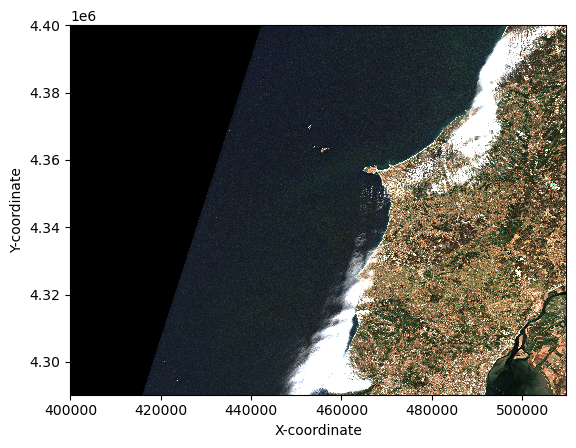

In [198]:
rgb=ds['tci']
rgb_normalized = (rgb - rgb.min()) / (rgb.max() - rgb.min())
rgb_normalized.plot.imshow()
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.grid(False) # Turn off grid for image plots
plt.axis('tight') # Ensure axes fit the data tightly

AttributeError: module 'matplotlib' has no attribute 'xlabel'

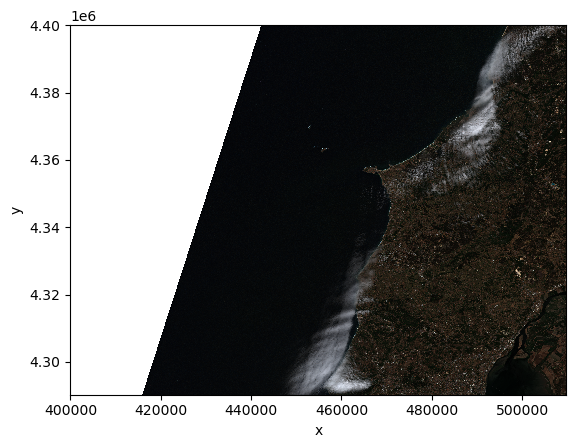

In [189]:
rgb = ds[['b04', 'b03', 'b02']].to_array().transpose('y', 'x', 'variable')

# Clip values to 0-1 range
rgb_clipped = rgb.clip(0, 1)

rgb_clipped.plot.imshow()
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.grid(False)
plt.axis('tight')

(np.float64(300000.0),
 np.float64(409800.0),
 np.float64(5290200.0),
 np.float64(5400000.0))

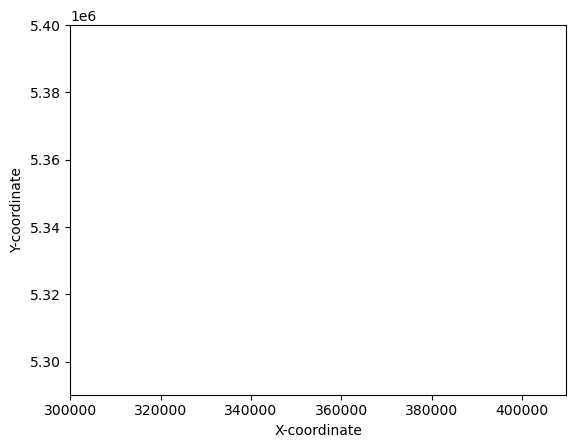

In [146]:
rgb = ds[['b04', 'b03', 'b02']].to_array().transpose('y', 'x', 'variable')

# Apply 2-98 percentile stretch
p2, p98 = np.percentile(rgb, (2, 98))
rgb_stretched = np.clip((rgb - p2) / (p98 - p2), 0, 1)

rgb_stretched.plot.imshow()
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.grid(False)
plt.axis('tight')

AttributeError: module 'matplotlib' has no attribute 'xlabel'

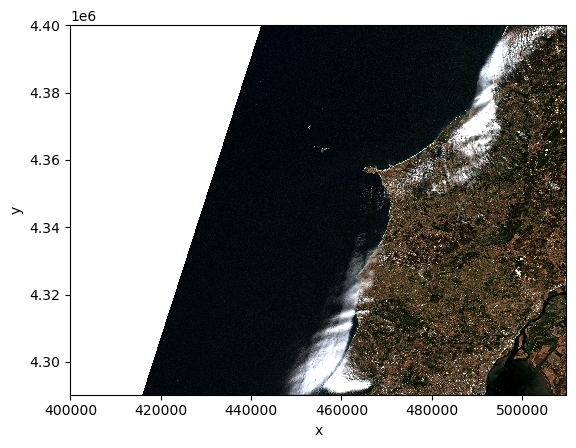

In [190]:
rgb = ds[['b04', 'b03', 'b02']].to_array().transpose('y', 'x', 'variable')

# Use robust=True for automatic percentile stretching
rgb.plot.imshow(robust=True)
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.grid(False)
plt.axis('tight')

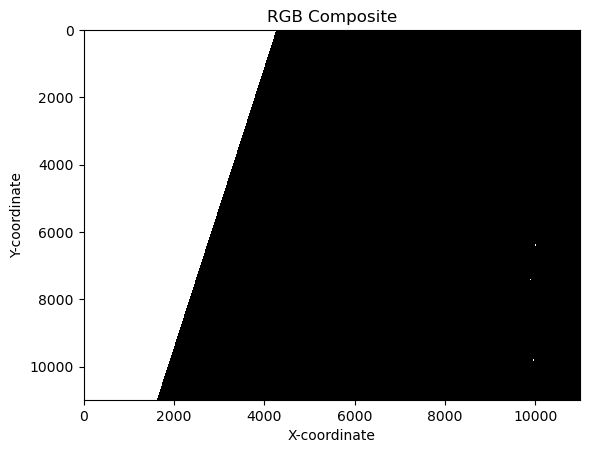

In [191]:
# Simple RGB composite with xarray dataset
import matplotlib.pyplot as plt
import numpy as np

# Create RGB composite from your dataset bands
#rgb = np.stack([ds['b04'], ds['b03'], ds['b02']], axis=-1)

# Normalize if needed (adjust based on your data range)
#rgb = rgb / rgb.max()  # or use specific max value like rgb / 10000

# Plot the composite
#plt.imshow(rgb, extent=[ds.x.min(), ds.x.max(), ds.y.min(), ds.y.max()])
#plt.title('RGB Composite')
#plt.xlabel('X-coordinate')
#plt.ylabel('Y-coordinate')
#plt.grid(False)
#plt.axis('tight')
#plt.show()

# Alternative if your bands are already in the right format:
rgb = ds[['b04', 'b03', 'b02']].to_array().transpose('y', 'x', 'variable')
rgb = rgb / 3000
rgb = np.clip(rgb, 0, 1)
plt.imshow(rgb)
plt.title('RGB Composite')
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.grid(False)
plt.axis('tight')
plt.show()